FAIRNESS XGBOOST

pré processamento

In [2]:
import pandas as pd
import numpy as np

In [3]:
#importando o banco pelo collab
from google.colab import files
uploaded = files.upload()

Saving datafairness.dta to datafairness.dta


In [5]:
import pandas as pd
# Substitua 'data.dta' pelo nome real do seu arquivo
df = pd.read_stata('datafairness.dta')

# Visualize as primeiras linhas do dataframe
df.head()

,TEMPODESLOC,TEMPOTOTAL,TEMPOEDFIS,TEMPOEXTRA,TEMPOEST,trabalha,cafedamanha,almojanta,comer_tvestuda,merenda,...,drogas,bullying,motivo_bullying,sozinho,insonia,amigos,imagem_imp,satisf_corp,imagem_corp,imc_cat_recoded
0,0.0,15.0,0.0,15.0,60.0,Não,"Sim, todos os dias","Sim, todos os dias",Não,Não,...,Nunca usou,Nunca,NaN,Nunca,Nunca,3 ou mais amigos,Muito importante,Satisfeito,Muito magro,Déficit de peso e Eutrofia
1,120.0,510.0,260.0,130.0,300.0,Não,Raramente,"Sim, todos os dias","Sim, todos os dias",Não,...,Nunca usou,Nunca,NaN,Na maior parte do tempo,Na maior parte do tempo,3 ou mais amigos,Pouco importante,Satisfeito,Normal,Déficit de peso e Eutrofia
2,0.0,585.0,130.0,455.0,420.0,Não,Raramente,"Sim, todos os dias","Sim, todos os dias",Sim,...,Nunca usou,Raramente,Outros motivos/causas,Nunca,Raramente,2 amigos,Muito importante,Satisfeito,Normal,Déficit de peso e Eutrofia
3,0.0,0.0,0.0,0.0,0.0,Não,"Sim, todos os dias","Sim, todos os dias",Raramente,Não,...,Nunca usou,Nunca,NaN,Raramente,Raramente,3 ou mais amigos,Muito importante,Satisfeito,Normal,Sobrepeso e Obesidade
4,30.0,165.0,90.0,45.0,60.0,Não,"Sim, todos os dias","Sim, todos os dias",Raramente,Sim,...,Nunca usou,Raramente,Aparência do corpo,Raramente,Raramente,3 ou mais amigos,Muito importante,Insatisfeito,Gordo,Sobrepeso e Obesidade


In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [7]:
# Verificar a presença de valores nulos
null_counts = df.isnull().sum()
print("Valores nulos em cada coluna:")
print(null_counts[null_counts > 0])

Valores nulos em cada coluna:
TEMPODESLOC           33
TEMPOTOTAL            20
TEMPOEDFIS            84
TEMPOEXTRA            93
TEMPOEST             110
trabalha              14
cafedamanha           12
almojanta             25
comer_tvestuda        15
merenda             1135
comemerenda         5445
feijao_7              36
salgado_7             37
legumeverdura_7       34
guloseima_7           39
frutas_7              37
refrigerante_7        29
aup_7                 50
fastfood_7            37
ficoucfome            30
frutas_30             46
legumeverdura_30      59
refrigerante_30       40
tempo_tv              50
tempo_telas           84
tabagismo           4729
alcool              4743
drogas              4741
bullying             103
motivo_bullying     9329
sozinho               66
insonia               77
amigos                67
imagem_imp           155
satisf_corp          181
imagem_corp          159
dtype: int64


In [8]:
# Identificar colunas categóricas e contínuas
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
continuous_cols = df.select_dtypes(include=['float64']).columns

In [9]:
# Tratamento de valores nulos
# Para variáveis contínuas: substituir nulos pela mediana
imputer_cont = SimpleImputer(strategy='median')
df[continuous_cols] = imputer_cont.fit_transform(df[continuous_cols])

In [10]:
# Para variáveis categóricas: substituir nulos pela moda
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

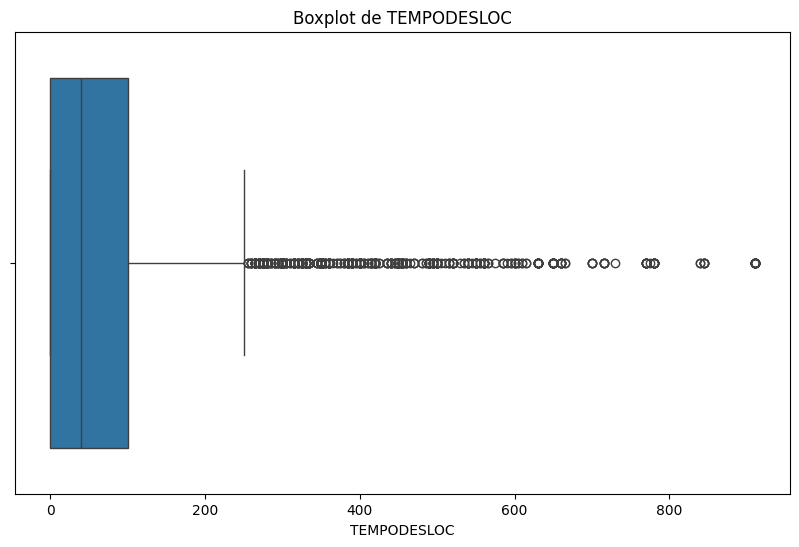

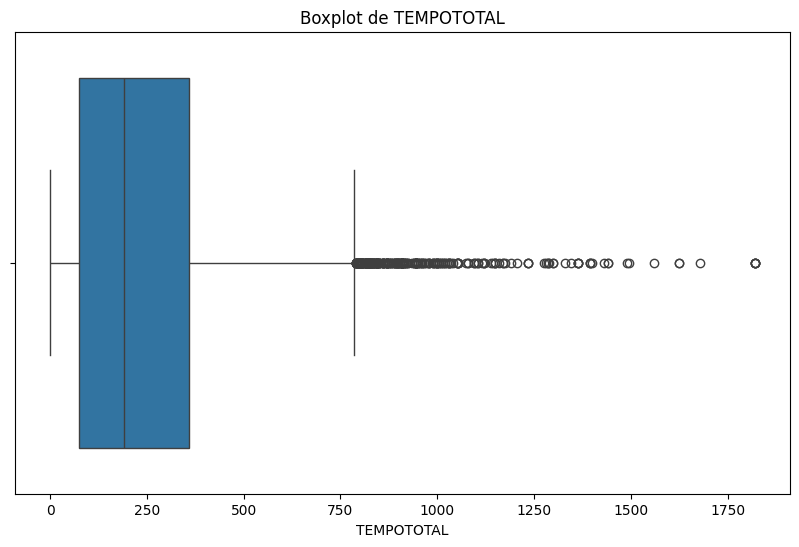

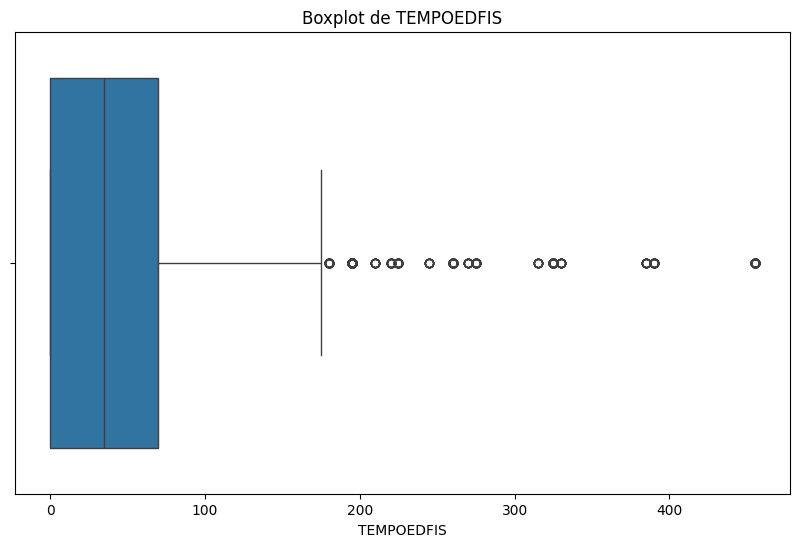

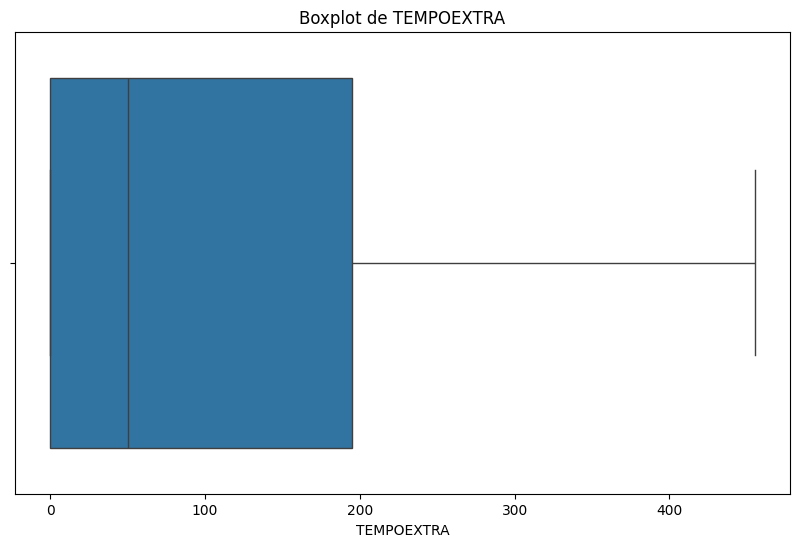

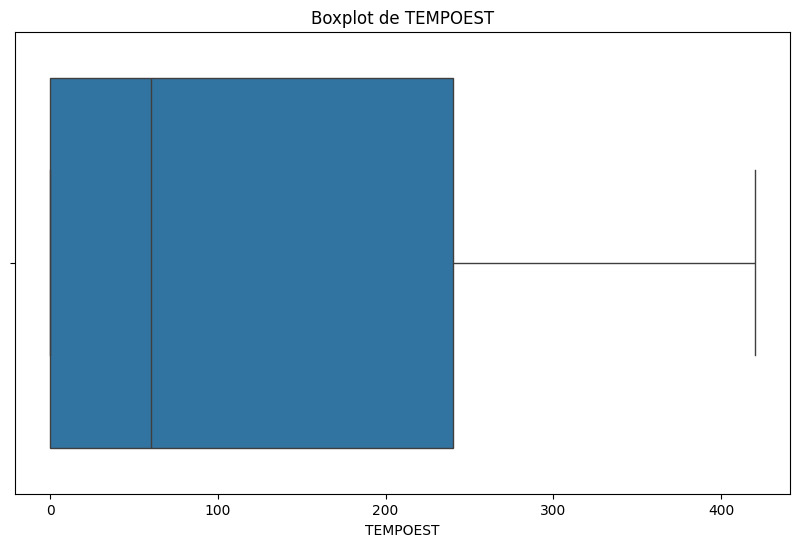

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemplo para múltiplas colunas
features = ['TEMPODESLOC', 'TEMPOTOTAL', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOEST']

# Criar boxplots para cada coluna
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot de {feature}')
    plt.show()

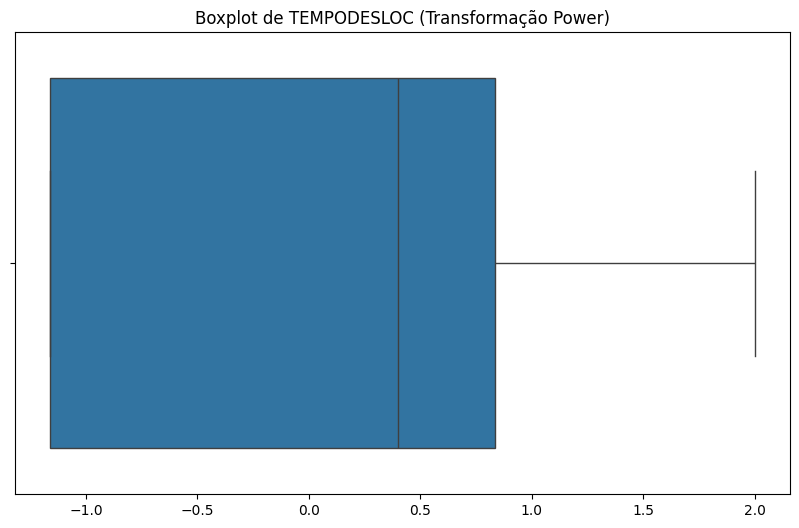

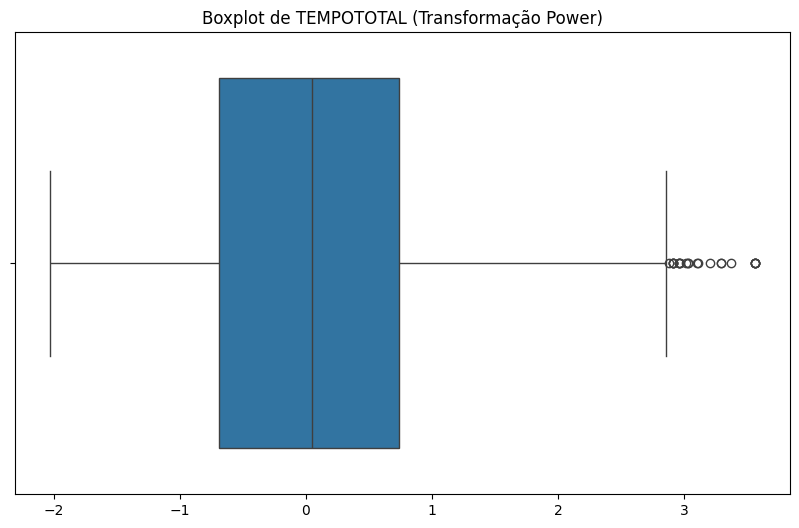

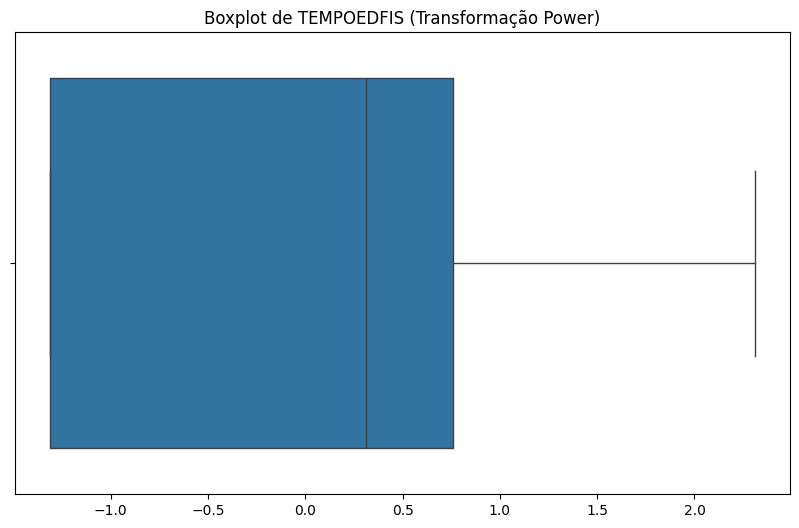

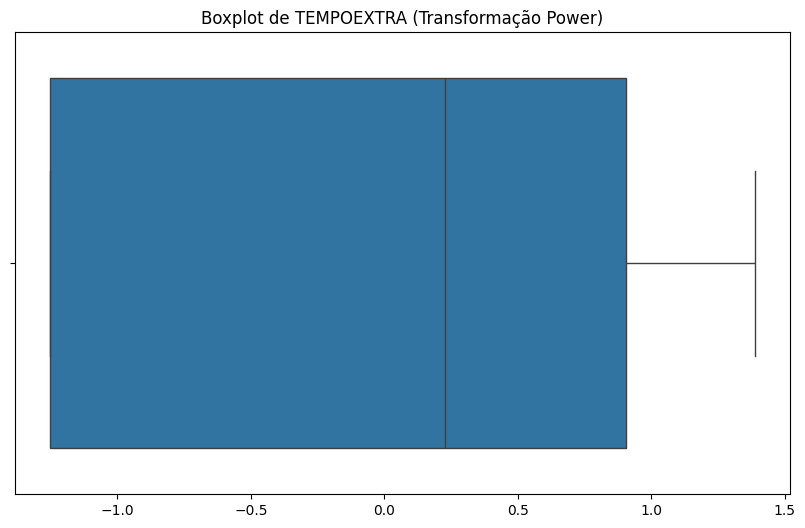

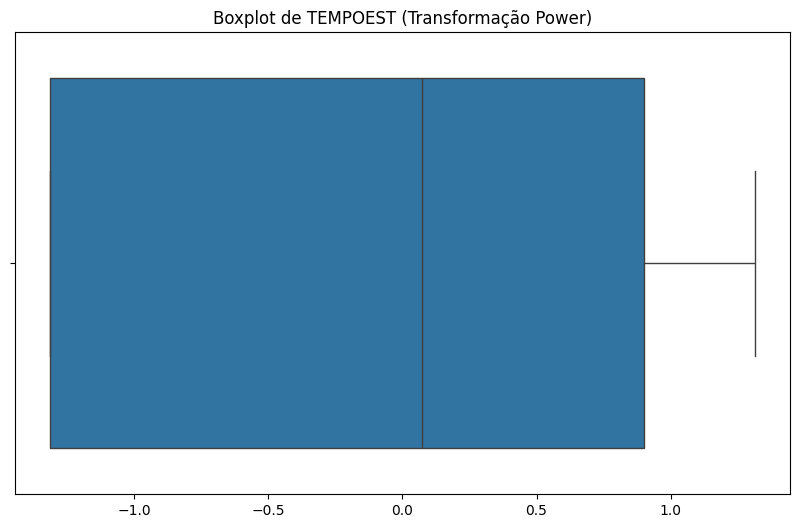

In [12]:
from sklearn.preprocessing import PowerTransformer

# Aplicando a transformação Power (Box-Cox ou Yeo-Johnson) e criando boxplots para cada coluna
pt = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' se os dados forem estritamente positivos

for feature in features:
    plt.figure(figsize=(10, 6))

    # A transformação Power é aplicada à coluna
    transformed_data = pt.fit_transform(df[[feature]])

    sns.boxplot(x=transformed_data.flatten())
    plt.title(f'Boxplot de {feature} (Transformação Power)')
    plt.show()

In [13]:
# Codificação de variáveis categóricas
# Usar OneHotEncoder para variáveis categóricas
ohe = OneHotEncoder(sparse=False, drop='first')
transformed_df = ohe.fit_transform(df[categorical_cols])
ohe_df = pd.DataFrame(transformed_df, columns=[f"{col}_{cat}" for col, categories in zip(categorical_cols, ohe.categories_) for cat in categories[1:]])
df = pd.concat([df.drop(categorical_cols, axis=1), ohe_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
# Normalização das variáveis contínuas
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

In [15]:
# Verificar a presença de valores nulos
null_counts = df.isnull().sum()
print("Valores nulos em cada coluna:")
print(null_counts[null_counts > 0])

Valores nulos em cada coluna:
Series([], dtype: int64)


In [16]:
df.head()

,TEMPODESLOC,TEMPOTOTAL,TEMPOEDFIS,TEMPOEXTRA,TEMPOEST,trabalha_Sim,cafedamanha_Raramente,"cafedamanha_Sim, 1 a 2 dias por semana","cafedamanha_Sim, 3 a 4 dias por semana","cafedamanha_Sim, 5 a 6 dias por semana",...,imagem_imp_Sem importância,satisf_corp_Insatisfeito,satisf_corp_Muito insatisfeito,satisf_corp_Muito satisfeito,satisf_corp_Satisfeito,imagem_corp_Magro,imagem_corp_Muito gordo,imagem_corp_Muito magro,imagem_corp_Normal,imc_cat_recoded_Sobrepeso e Obesidade
0,-0.662734,-1.077921,-0.798740,-0.702443,-0.523275,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.391249,1.276770,3.402980,0.089315,1.205331,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.662734,1.633541,1.302120,2.326892,2.069635,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.662734,-1.149275,-0.798740,-0.805716,-0.955427,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,-0.399238,-0.364378,0.655701,-0.495898,-0.523275,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
# Mostrar os nomes das colunas no DataFrame
print(df.columns.tolist())

['TEMPODESLOC', 'TEMPOTOTAL', 'TEMPOEDFIS', 'TEMPOEXTRA', 'TEMPOEST', 'trabalha_Sim', 'cafedamanha_Raramente', 'cafedamanha_Sim, 1 a 2 dias por semana', 'cafedamanha_Sim, 3 a 4 dias por semana', 'cafedamanha_Sim, 5 a 6 dias por semana', 'cafedamanha_Sim, todos os dias', 'almojanta_Raramente', 'almojanta_Sim, 1 a 2 dias por semana', 'almojanta_Sim, 3 a 4 dias por semana', 'almojanta_Sim, 5 a 6 dias por semana', 'almojanta_Sim, todos os dias', 'comer_tvestuda_Raramente', 'comer_tvestuda_Sim, 1 a 2 dias por semana', 'comer_tvestuda_Sim, 3 a 4 dias por semana', 'comer_tvestuda_Sim, 5 a 6 dias por semana', 'comer_tvestuda_Sim, todos os dias', 'merenda_Sim', 'comemerenda_Raramente', 'comemerenda_Sim, 1 a 2 dias por semana', 'comemerenda_Sim, 3 a 4 dias por semana', 'comemerenda_Sim, todos os dias', 'feijao_7_2 dias nos últimos 7 dias', 'feijao_7_3 dias nos últimos 7 dias', 'feijao_7_4 dias nos últimos 7 dias', 'feijao_7_5 dias nos últimos 7 dias', 'feijao_7_6 dias nos últimos 7 dias', 'feija

In [18]:
# Separar as variáveis independentes (X) da variável dependente (y)
X = df.drop('imc_cat_recoded_Sobrepeso e Obesidade', axis=1)
y = df['imc_cat_recoded_Sobrepeso e Obesidade']

In [19]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear as classes no conjunto de treinamento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [21]:
# Verificar o balanceamento
print("Distribuição das classes após SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Distribuição das classes após SMOTE:
imc_cat_recoded_Sobrepeso e Obesidade
1.0    9611
0.0    9611
Name: count, dtype: int64


In [22]:
# Import folds
from sklearn.model_selection import StratifiedKFold

# Configurar o K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [23]:
# Treinar o modelo XGBoost com os dados balanceados
model = XGBClassifier(
    use_label_encoder=False,  # Evita warnings de codificação de rótulos
    eval_metric='logloss',    # Métrica de avaliação
    random_state=42
)
model.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:43:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
!pip install optuna
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00


In [25]:
# Definir a função de objetivo para otimização do Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        random_state=42
    )
    # Definir a função de objetivo para otimização do Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        random_state=42
    )

    # Cross-validation usando StratifiedKFold
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    return score.mean()

# Criar o estudo e otimizar com Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros:", study.best_params)

# Melhor resultado
print("Melhor score:", study.best_value)

[I 2024-08-21 13:59:07,029] A new study created in memory with name: no-name-f820425d-7b8b-4e2e-a8ba-137160a0088e
<ipython-input-25-713275a4ad7c>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:59:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:59:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:59:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label

Melhores hiperparâmetros: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.15619207231417437, 'subsample': 0.786904968253995, 'colsample_bytree': 0.8696319726567965}
Melhor score: 0.8024761443310722


In [27]:
# Treinar o modelo com os melhores hiperparâmetros encontrados
best_model = XGBClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    use_label_encoder=False,
    random_state=42
)

best_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:16:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8696319726567965, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15619207231417437,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=93, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prever no conjunto de treino
y_train_pred = best_model.predict(X_train)

# Calcular as métricas no conjunto de treino
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='binary')
recall_train = recall_score(y_train, y_train_pred, average='binary')
f1_train = f1_score(y_train, y_train_pred, average='binary')

# Armazenar as métricas em um dicionário
metrics_train = {
    'Acurácia': accuracy_train,
    'Precision': precision_train,
    'Recall': recall_train,
    'F1 Score': f1_train
}

# Exibir as métricas
print("Métricas no conjunto de treino:")
for metric, value in metrics_train.items():
    print(f"{metric}: {value:.4f}")


Métricas no conjunto de treino:
Acurácia: 0.8091
Precision: 0.7190
Recall: 0.4993
F1 Score: 0.5893


In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Suponha que você já tenha o modelo otimizado (best_model) e os dados de treino (X_train, y_train)

# 1. Exibir os melhores parâmetros encontrados durante a otimização com Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# 2. Exibir a melhor pontuação de validação cruzada obtida durante a otimização
best_cv_score = study.best_value
print("Best Cross-Validation Score:", best_cv_score)

# 3. Avaliar o modelo no conjunto de treino
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# 4. Exibir o relatório de classificação no conjunto de treino
train_classification_report = classification_report(y_train, y_train_pred)
print("Train Classification Report:")
print(train_classification_report)

# 5. Exibir a matriz de confusão no conjunto de treino
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
print("Train Confusion Matrix:")
print(train_confusion_matrix)

# 6. Opcional: Se você quiser formatar a matriz de confusão como no exemplo fornecido
formatted_confusion_matrix = "\n".join([" ".join(map(str, row)) for row in train_confusion_matrix])
print("Formatted Confusion Matrix:")
print(formatted_confusion_matrix)


Best Parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.15619207231417437, 'subsample': 0.786904968253995, 'colsample_bytree': 0.8696319726567965}
Best Cross-Validation Score: 0.8024761443310722
Train Accuracy: 0.8091211114466929
Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88      9611
         1.0       0.72      0.50      0.59      3633

    accuracy                           0.81     13244
   macro avg       0.77      0.71      0.73     13244
weighted avg       0.80      0.81      0.80     13244

Train Confusion Matrix:
[[8902  709]
 [1819 1814]]
Formatted Confusion Matrix:
8902 709
1819 1814


In [32]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Suponha que você já tenha o modelo otimizado (best_model) e os dados de teste (X_test, y_test)

# 1. Exibir os melhores parâmetros encontrados durante a otimização com Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# 2. Exibir a melhor pontuação de validação cruzada obtida durante a otimização
best_cv_score = study.best_value
print("Best Cross-Validation Score:", best_cv_score)

# 3. Avaliar o modelo no conjunto de teste
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# 4. Exibir o relatório de classificação no conjunto de teste
test_classification_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:")
print(test_classification_report)

# 5. Exibir a matriz de confusão no conjunto de teste
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(test_confusion_matrix)

# 6. Opcional: Se você quiser formatar a matriz de confusão como no exemplo fornecido
formatted_confusion_matrix = "\n".join([" ".join(map(str, row)) for row in test_confusion_matrix])
print("Formatted Confusion Matrix:")
print(formatted_confusion_matrix)



Best Parameters: {'n_estimators': 93, 'max_depth': 3, 'learning_rate': 0.15619207231417437, 'subsample': 0.786904968253995, 'colsample_bytree': 0.8696319726567965}
Best Cross-Validation Score: 0.8024761443310722
Test Accuracy: 0.8073671497584541
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      2403
         1.0       0.70      0.51      0.59       909

    accuracy                           0.81      3312
   macro avg       0.77      0.72      0.73      3312
weighted avg       0.80      0.81      0.80      3312

Test Confusion Matrix:
[[2208  195]
 [ 443  466]]
Formatted Confusion Matrix:
2208 195
443 466


In [38]:
# Assumindo 'cv_results' is a pandas DataFrame reultado da cross-validation
cv_results = pd.DataFrame() #replacing

# Mostrar os primeiros resultados
print(cv_results.head())

Empty DataFrame
Columns: []
Index: []


In [39]:
# Assumindo 'cv_results' is a pandas DataFrame reultado da cross-validation
# cv_results = pd.DataFrame() #mudad=nod -> This line creates an empty dataframe
# Instead, you should have a DataFrame with the results of your cross-validation here.
# For example:
cv_results = pd.DataFrame({
    'params': [{'param1': 1}, {'param1': 2}],
    'mean_test_score': [0.8, 0.9],
    'std_test_score': [0.1, 0.05]
})

# Mostrar os primeiros resultados
print(cv_results.head())

# Visualizar as 5 melhores combinações de hiperparâmetros
top_5_results = cv_results.nlargest(5, 'mean_test_score')
print(top_5_results[['params', 'mean_test_score', 'std_test_score']])

          params  mean_test_score  std_test_score
0  {'param1': 1}              0.8            0.10
1  {'param1': 2}              0.9            0.05
          params  mean_test_score  std_test_score
1  {'param1': 2}              0.9            0.05
0  {'param1': 1}              0.8            0.10


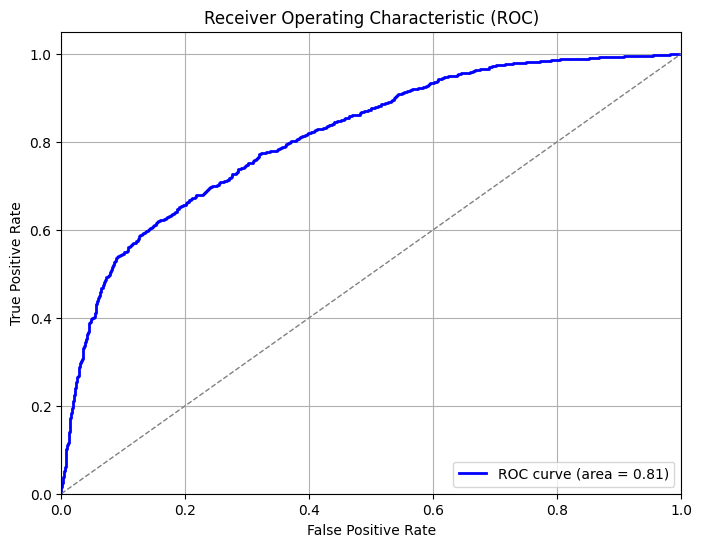

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Fazer predições de probabilidade no conjunto de teste
y_test_pred_proba = best_model.predict_proba(X_test)

# Calcular a curva ROC e a área sob a curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [42]:
!pip install shap

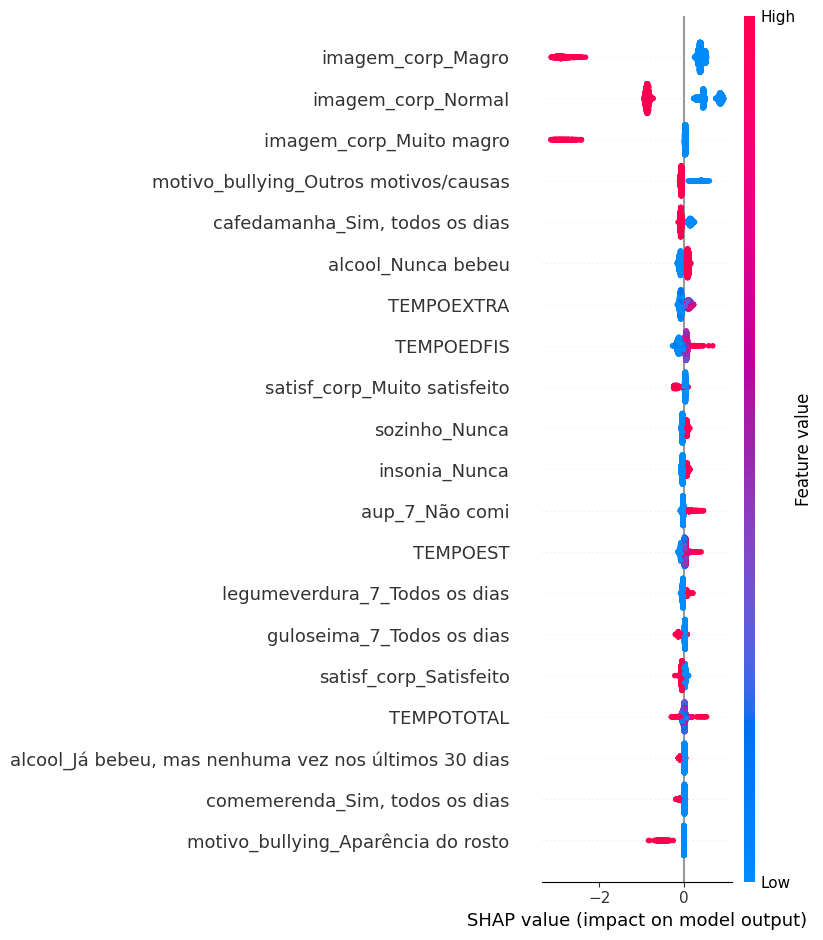

In [43]:
import shap

# Criar um objeto explainer para o modelo
explainer = shap.Explainer(best_model, X_train_balanced)

# Calcular os valores SHAP para o conjunto de teste
shap_values = explainer(X_test)

# Plotar o gráfico SHAP summary
shap.summary_plot(shap_values, X_test)

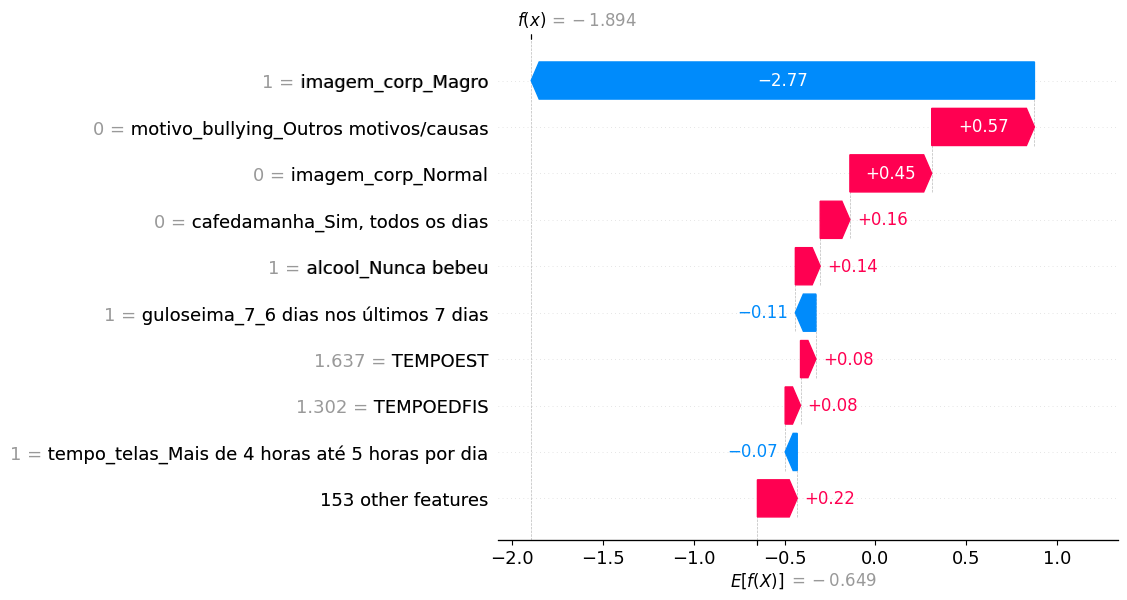

In [44]:
# Escolher uma observação para explicar
index = 0  # Índice da observação no conjunto de teste
shap.plots.waterfall(shap_values[index])

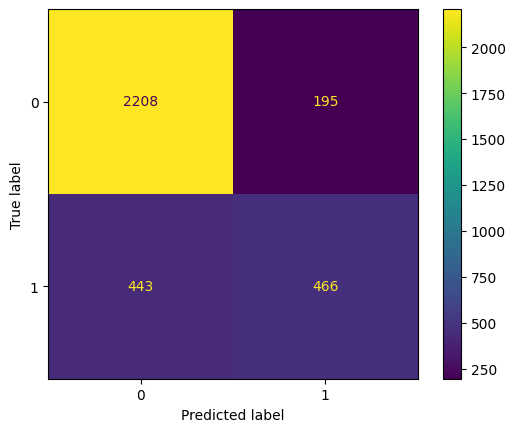

In [45]:
# Criar a matriz de confusão
y_pred = best_model.predict(X_test)  # Generate predictions using your best model
cm = confusion_matrix(y_test, y_pred)

# Import ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay

# Exibir a matriz de confusão usando ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot() # Add this to display the confusion matrix
plt.show()

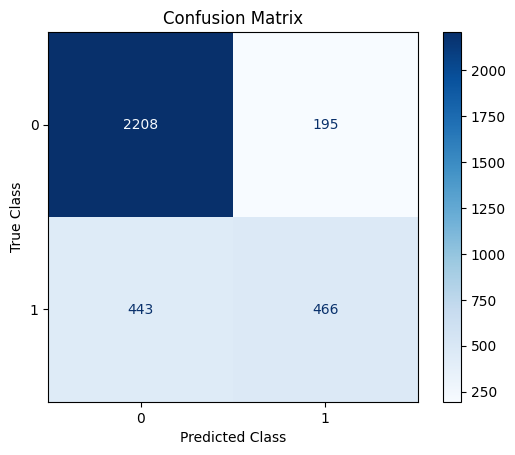

In [46]:
# Configurando o estilo da plotagem para se assemelhar à imagem fornecida
disp.plot(cmap='Blues', values_format='d')

# Ajustar título, labels e exibir o gráfico
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()